# PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

Your data is ready! Merged table name is zillow_full.


In [ ]:
%run ../Jane/extract_data.py

In [2]:
zillow_full = zillow_full.drop(['PersonalIncome','AQIMean','Vol_moderate_income','Vol_low_income'],axis=1)

In [3]:
zillow_full.sample()

,Zipcode,City,State,Metro,County,SizeRank,Date,Rent,Year,State-County,...,pct_poverty,housing_availability,home_density,pct_employed,pct_jobs_nightlife,pct_unemployed,move_within_city,move_new_city,avg_commute_time,pct_college
13559,11365,New York,NY,New York-Newark-Jersey City,Queens County,915,2018-11-01,2226.0,2018,NY-Queens County,...,0.118737,1.042836,2.888896,0.909333,0.094225,0.090667,0.059778,0.01983,43.777289,0.160483


In [4]:
# separate the cols that won't go into the pca
zillow = zillow_full[['Zipcode','City','State','Metro','County','SizeRank','Date','Rent','Year','State-County']]
features = zillow_full.drop(['Zipcode','City','State','Metro','County','SizeRank','Date','Rent',
                             'Year','State-County'], axis = 1).copy()

In [6]:
scaler = StandardScaler()

features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns)
features.head()

,total_pop,households,median_age,median_income,income_per_capita,gini_index,pct_poverty,housing_availability,home_density,pct_employed,pct_jobs_nightlife,pct_unemployed,move_within_city,move_new_city,avg_commute_time,pct_college
0,2.052326,3.096986,0.677914,0.395570,1.127500,2.090545,-0.116861,0.165373,-0.951186,-0.203258,-0.502295,0.218105,0.557787,-0.131412,-0.253440,0.459031
1,0.708930,2.065297,1.069040,1.794826,2.899726,1.450117,-0.854462,0.768800,-1.658710,0.635772,-0.646796,-0.606914,0.220614,-0.386784,-0.603104,1.019498
2,1.264424,2.046087,1.127709,-1.178083,-0.401966,1.861821,1.410115,-0.524889,-0.909010,-0.314296,1.564514,0.339607,-0.408679,-0.828548,-0.196208,-0.075481
3,2.382845,2.446985,-0.612804,-0.669162,-0.655060,-0.261799,0.216671,-0.271246,0.058214,-0.382420,-0.115327,0.407477,-0.598288,-0.990002,1.160614,-0.619263
4,2.535674,2.446860,-0.808367,-1.141751,-0.920356,0.053137,1.436812,-0.650615,0.242537,-2.372156,0.573144,2.389787,0.799210,-1.038250,1.299683,-1.127515


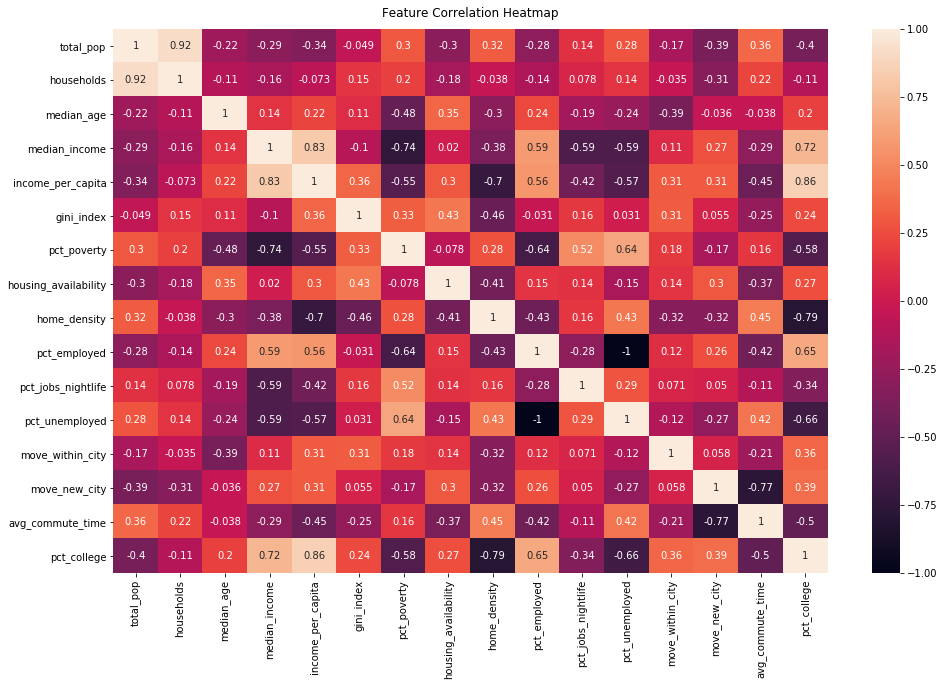

In [7]:
# # try a correlation heat map to assess for multicollinearity
plt.figure(figsize=(16, 10)) # larger for ease of viewing

heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

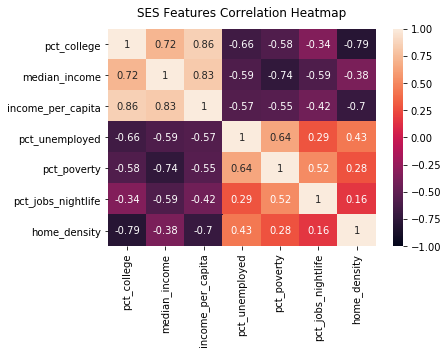

In [24]:
socioeconomic = features[['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density']]
heatmap = sns.heatmap(socioeconomic.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('SES Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [120]:
socioeconomic.sample()

,pct_college,median_income,income_per_capita,pct_unemployed,pct_poverty,pct_jobs_nightlife,home_density
1505,2.032516,1.627879,2.927411,-1.301399,-1.226165,-1.190781,-1.590856


In [121]:
def screePlot(df):
    pca = PCA(n_components=df.shape[1]) 
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    plt.plot((np.arange(pca.n_components_)+1), pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('# Principal Components')
    plt.ylabel('% of Variance Explained')
    plt.show()

[0.6307501  0.15998221 0.0933639  0.05347054 0.03849601 0.01508871
 0.00884853]


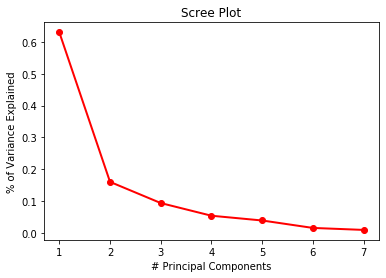

In [122]:
screePlot(socioeconomic) # take 3 pcs

In [202]:
pca = PCA(n_components=7)
pca.fit_transform(socioeconomic).shape

(17751, 7)

In [33]:
pca = PCA(n_components=3) 
econPC = pd.DataFrame(pca.fit_transform(socioeconomic),columns=['econPC1','econPC2','econPC3'])

### remove features involved in the above PCA

In [34]:
features = features.drop(['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density'],axis=1)

In [62]:
features = features.drop(['pct_employed'],axis=1)

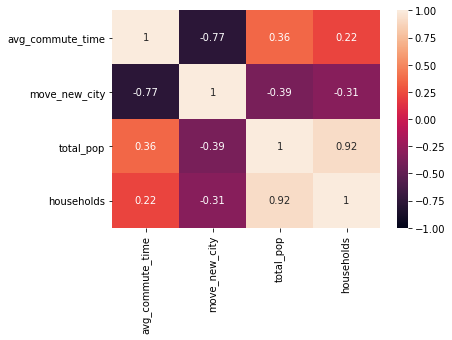

In [102]:
cityfeats = features[['avg_commute_time','move_new_city','total_pop','households']]
heatmap = sns.heatmap(cityfeats.corr(), vmin=-1, vmax=1, annot=True)

[0.62361709 0.30134057 0.05814203 0.01690031]


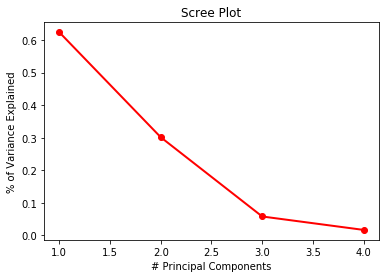

In [103]:
screePlot(cityfeats) # 2PCs

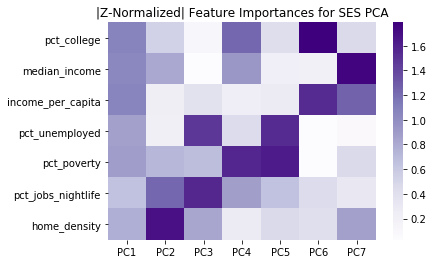

In [208]:
pca = PCA(n_components=7)
pca.fit_transform(socioeconomic)
idx = socioeconomic.columns.to_list()
idx
dotprod_df = pd.DataFrame(np.dot(socioeconomic.T,pca.fit_transform(socioeconomic)),columns=['PC1','PC2','PC3','PC4','PC5',
                                                                                   'PC6','PC7'])
dotprod_df.index = idx
df_norm = (dotprod_df.copy()-dotprod_df.mean())/dotprod_df.std()
df_abs = df_norm.copy().abs().set_index(df_norm.index)

plt.figure()
ax_abs = sns.heatmap(df_abs, cmap="Purples")
ax_abs.set_title("|Z-Normalized| Feature Importances for SES PCA")
plt.show()

In [204]:
pca = PCA(n_components=4)
pca.fit_transform(cityfeats)
idx = cityfeats.columns.to_list()
idx

['avg_commute_time', 'move_new_city', 'total_pop', 'households']

In [205]:
dotprod_df = pd.DataFrame(np.dot(cityfeats.T,pca.fit_transform(cityfeats)),columns=['PC1','PC2','PC3','PC4'])
dotprod_df.index = idx
df_norm = (dotprod_df.copy()-dotprod_df.mean())/dotprod_df.std()
df_abs = df_norm.copy().abs().set_index(df_norm.index)

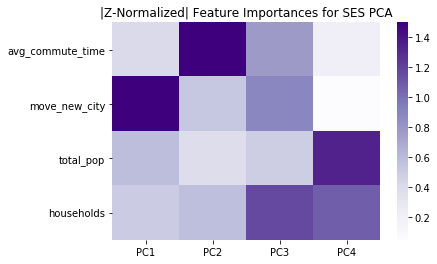

In [206]:
plt.figure()
ax_abs = sns.heatmap(df_abs, cmap="Purples")
ax_abs.set_title("|Z-Normalized| Feature Importances for SES PCA")
plt.show()

In [104]:
pca = PCA(n_components=2) 
cityPC = pd.DataFrame(pca.fit_transform(cityfeats),columns=['cityPC1','cityPC2'])

In [117]:
zillow_withPCA = pd.concat((zillow,features,cityPC,econPC),axis=1)
zillow_withPCA.set_index('Date',inplace=True)
zillow_withPCA.sample()

,Zipcode,City,State,Metro,County,SizeRank,Rent,Year,State-County,median_age,gini_index,housing_availability,move_within_city,cityPC1,cityPC2,econPC1,econPC2,econPC3
Date,,,,,,,,,,,,,,,,,,
2015-01-01,11356,New York,NY,New York-Newark-Jersey City,Queens County,1763,1962.0,2015,NY-Queens County,-0.143452,-0.794903,-0.249751,-0.626933,-0.366381,1.966017,-0.681528,-1.096247,-1.086131


In [227]:
zillow_withPCA.to_csv('../../data/zillow_withPCA.csv')

## random forest

In [223]:
# all code moved to pcarandomforest.py

In [224]:
X,y = preProc(zillow_withPCA,ytype='log')
Xtrain,Xtest,ytrain,ytest = train_test(X,y)

In [225]:
Xtrain = Xtrain.drop(['Zipcode','City','Metro','County','SizeRank','Year'],axis=1)
Xtest = Xtest.drop(['Zipcode','City','Metro','County','SizeRank','Year'],axis=1)

In [226]:
rfc = RandomForestRegressor(n_estimators=600)
randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.9759590138339153
test R2: 0.947421210165156
RMSE: 135.20093603257953


,Columns,Feature_importances
6,econPC1,0.407102
1,gini_index,0.130022
2,housing_availability,0.106495
4,cityPC1,0.096303
3,move_within_city,0.091412
8,econPC3,0.079588
0,median_age,0.042162
7,econPC2,0.026000
5,cityPC2,0.020916


In [129]:

rfc = RandomForestRegressor()

randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.999435677448131
test R2: 0.9839755073003001
RMSE: 0.035879181285339075


,Columns,Feature_importances
2,Metro,0.392328
14,econPC1,0.268005
0,Zipcode,0.136307
15,econPC2,0.068581
3,County,0.033059
16,econPC3,0.027631
6,PersonalIncome,0.014401
4,SizeRank,0.009501
9,cityPC1,0.009428
17,econPC4,0.009233


In [131]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## grid search to parameter tune

In [229]:
param_grid = {'n_estimators':[250,300,400,500,700,1000],
              'max_features':['auto','sqrt','log2'],
              'min_samples_split':[2,5,10,15,20,50],
              'min_samples_leaf':[1,2,5,10,15]
             }

grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid,return_train_score=True)

In [230]:
# started running at 12:37:30
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [233]:
grid.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 250}

In [247]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_)
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [253]:
grid_results[['param_max_features','param_min_samples_leaf','param_min_samples_split','param_n_estimators',
             'mean_test_score','mean_train_score','rank_test_score']].sort_values('rank_test_score').head(20)

,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score,rank_test_score
258,sqrt,5,5,250,0.965568,0.977268,1
468,log2,10,2,250,0.965565,0.977268,2
277,sqrt,5,20,300,0.965563,0.977268,3
415,log2,2,15,300,0.965558,0.977269,4
234,sqrt,2,15,250,0.965557,0.977268,5
270,sqrt,5,15,250,0.965557,0.977268,6
223,sqrt,2,5,300,0.965556,0.977268,7
432,log2,5,2,250,0.965556,0.977268,8
126,auto,10,15,250,0.965556,0.977268,9
116,auto,10,5,400,0.965554,0.977269,10


In [258]:
rfc = RandomForestRegressor(max_features='sqrt',n_estimators=500)
param_grid = {'min_samples_split':[10,20,30,50,100],
              'min_samples_leaf':[5,10,20,35,50]
             }

grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid,return_train_score=True)

In [259]:
# started at 6:10pm
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [265]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_)
grid_results.sort_values('rank_test_score')[['param_min_samples_leaf','param_min_samples_split','rank_test_score','mean_train_score','mean_test_score']]

,param_min_samples_leaf,param_min_samples_split,rank_test_score,mean_train_score,mean_test_score
7,10,30,1,0.977265,0.965530
6,10,20,2,0.977265,0.965529
0,5,10,3,0.977265,0.965525
5,10,10,4,0.977265,0.965524
2,5,30,5,0.977264,0.965512
1,5,20,6,0.977265,0.965491
12,20,30,7,0.977170,0.965460
10,20,10,8,0.977159,0.965419
11,20,20,9,0.977161,0.965387
13,20,50,10,0.976400,0.964665
